In [1]:
import pandas as pd
import numpy as np

# 데이터 관련
from sklearn.preprocessing import LabelEncoder, StandardScaler  # 레이블 변환(0, 1) , 표준정규화
from sklearn.decomposition import PCA # 차원축소
from sklearn.model_selection import train_test_split

#파이프라인
from sklearn.pipeline import make_pipeline  
from sklearn import set_config  # 파이프라인 확인

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier  
from sklearn.ensemble import RandomForestClassifier


# 평가 지표
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score # 정확도

# 모델 선택 및 교차검증 관련
from sklearn.model_selection import cross_val_score     # 모델 선택, 교차검증 (1개지표만)
from sklearn.model_selection import cross_validate      # 여러개 평가 지표 반환, 수행시간 반환
from sklearn.model_selection import cross_val_predict   # 각 폴드에 대해 예측성능 평가
from sklearn.model_selection import learning_curve      # 학습곡선 
from sklearn.model_selection import validation_curve    # 학습곡선 검증
from sklearn.model_selection import StratifiedKFold     # k-겹 교차 검증

# 최적화 
from sklearn.model_selection import GridSearchCV        # 격자 탐색
from sklearn.model_selection import RandomizedSearchCV  # 랜덤 탐색
from sklearn.model_selection import KFold               # K-겹 교차검증
from hyperopt import fmin, tpe, Trials, STATUS_OK       # 하이퍼 옵트
from hyperopt import hp                     # 하이퍼 옵트의 검색공간 정의

# 시각화
import matplotlib.pylab as plt
from sklearn.model_selection import LearningCurveDisplay  # 학습곡선 시각화
from sklearn.metrics import ConfusionMatrixDisplay  # 혼동행렬 시각화
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 위스콘신 유방암 데이터셋
cancer_df=pd.read_csv(
    './wdbc.data'
    , header=None
)
cancer_df.head()

# 1 = 답 : 문자열이므로 숫자로 변경. 
# 0 = 환자번호 : 필요없을듯

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 데이터 확인

In [3]:
cancer_df.info()

# NaN 없음, (569, 32) : 2개피쳐 삭제 예정
# 레이블 : 문자열 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       569 non-null    int64  
 1   1       569 non-null    object 
 2   2       569 non-null    float64
 3   3       569 non-null    float64
 4   4       569 non-null    float64
 5   5       569 non-null    float64
 6   6       569 non-null    float64
 7   7       569 non-null    float64
 8   8       569 non-null    float64
 9   9       569 non-null    float64
 10  10      569 non-null    float64
 11  11      569 non-null    float64
 12  12      569 non-null    float64
 13  13      569 non-null    float64
 14  14      569 non-null    float64
 15  15      569 non-null    float64
 16  16      569 non-null    float64
 17  17      569 non-null    float64
 18  18      569 non-null    float64
 19  19      569 non-null    float64
 20  20      569 non-null    float64
 21  21      569 non-null    float64
 22  22

In [4]:
# 데이터와 레이블 분리
X=cancer_df.iloc[:,2:].values  # -> array 0,1 index제외하고 가져옴
y=cancer_df.iloc[:,1]   # 답 

print(X.shape,y.shape)  # (569, 30) (569,)

print(np.unique(y))   # 레이블 종류 확인
print(pd.Series(y).value_counts())  # 레이블 개수 확인: B: 357, M: 212

(569, 30) (569,)
['B' 'M']
1
B    357
M    212
Name: count, dtype: int64


In [5]:
type(y)

pandas.core.series.Series

In [6]:
le=LabelEncoder()       
y=le.fit_transform(y)   # 레이블 인코딩(0,1)해서 다시 y에 입력
print(np.unique(y))     # -> array([0, 1])  
print(pd.Series(y).value_counts())  # 갯수가 맞는지 확인 (0:양성 B 357, 1:악성 M 212)


[0 1]
0    357
1    212
Name: count, dtype: int64


In [7]:
y=le.fit_transform(y)
print(pd.Series(y).value_counts()) #인코딩 됬는지 확인
print(type(y))

0    357
1    212
Name: count, dtype: int64
<class 'numpy.ndarray'>


In [8]:
pd.Series(y).value_counts()[1]/pd.Series(y).value_counts().sum()
# 악성의 비율이 약 37% 
# 처음엔 그대로 사용해보고 정규화 등 다른 전처리 해보기로 한다. 

np.float64(0.37258347978910367)

In [9]:
cancer_df.iloc[:,2:].describe()
# 평균 차이 많이나서 표준정규화 필요
# 차원이 넘 많아 차원 축소 필요(PCS)

,2,3,4,5,6,7,8,9,10,11,...,22,23,24,25,26,27,28,29,30,31
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 전처리

In [10]:
# cancer_df['0'] # 에러남
# cancer_df.iloc[0]  # 0 row 정보
# cancer_df[0] # 0 인덱스
cancer_df.iloc[:,0]  # 0 인덱스


0        842302
1        842517
2      84300903
3      84348301
4      84358402
         ...   
564      926424
565      926682
566      926954
567      927241
568       92751
Name: 0, Length: 569, dtype: int64

In [11]:
# cancer_df.drop('0', axis=1) : 에러
cancer_df.drop(0, axis=1)

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [12]:
# 전처리 함수: 원본 복사, 필요없는 피처는 삭제
def get_preprocessed_df(df=None):
    df_copy = df.drop(0, axis=1) # 0 피쳐(환자번호) 삭제해서 리턴
    return df_copy

In [13]:
# 전처리 데이터 분리 함수: 학습/테스트로 분리
def get_train_test_dataset(df=None):  # df가 None이면 에러라서 if를 주면 좋다.  if not df: # df가 None 아니면 아래 코드 실행
    df_copy = get_preprocessed_df(df) # Time 피쳐 drop하는 함수. df 없으면 여기서 에러가 남
    X_features = df_copy.iloc[:,1:] # 데이터 분리
    y_target = df_copy.iloc[:,0]    # 레이블 분리
    # 레이블 인코딩  : 정규화 등은 이 위에서 실행
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()  
    y_target=le.fit_transform(y_target)  # -> ndarray를 반환함 (X는df. 두개 타입이 달라 분리할때 에러가 나는지 봐야한다.)
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.2, random_state=1, stratify=y_target 
    )  # stratify=y_target: 답의 비율 맞춰서 나눔
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환 

In [14]:
# 데이터 분리 : 원본 = cancer_df
X_train, X_test, y_train, y_test = get_train_test_dataset(cancer_df) # 학습/테스트 분리
X_train.shape, X_test.shape     # 훈련 / 테스트 샘플수 확인 ((455, 30), (114, 30))

((455, 30), (114, 30))

In [15]:
# 저장할 딕셔너리 준비 : 모델별로 분리
lr_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

svm_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

forest_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

xgb_metric = {
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    '정확도': [],
    '정밀도': [],
    '재현율': [],
    'F1': [],
    'AUC': []
}

# 평가 결과를 딕셔너리(dict)로 저장하는 함수
def add_result_dict(model_metric, model_result):
    if '오차행렬' in model_result:
        tn, fp = model_result['오차행렬'][0]  # 키값으로 선택하고 인덱스로 접근한다. 
        fn, tp = model_result['오차행렬'][1]
        
        model_metric['TN'].append(tn)   # 입력하기 
        model_metric['FP'].append(fp)
        model_metric['FN'].append(fn)
        model_metric['TP'].append(tp)
    
    # 나머지는 키값으로 바로 불러지므로 딕셔너리에 바로 추가
    for x in ['정확도', '정밀도', '재현율', 'F1', 'AUC']:
        if x in model_result: # 해당지표가 결과dict에 있다면 입력 
            model_metric[x].append(model_result[x])

In [16]:
# 평가를 출력하고 기록하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    # 결과를 기록
    result = {
        '오차행렬': confusion.tolist(),
        '정확도': round(accuracy,4),
        '정밀도': round(precision,4),
        '재현율': round(recall,4),
        'F1': round(f1,4),
        'AUC': round(roc_auc,4)
    }
    print(result)
    return result

In [17]:
# 학습, 예측, 예측률, 평가(함수호출)하는 함수
def get_model_train_eval(
        model,              # 모델
        features_train=None,
        features_test=None, # 데이터
        target_train=None,
        target_test=None):  # 레이블
    model.fit(features_train, target_train) # 학습
    pred = model.predict(features_test) # 예측:일반화성능
    pred_proba =  model.predict_proba(features_test)[:,1] # 예측확률, 악성(1) 확률만 가져옴
    # 평가함수를 호출해서 일반화 성능 평가
    result = get_clf_eval(target_test, pred, pred_proba)
    return result

In [18]:
# 함수가 잘 돌아가는지 테스트하기 위해 수동으로 결과 받기 # 위 함수 적용해서 값이 같다면 안심하고 쓰면됨
lr_clf = LogisticRegression(random_state=1)
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba= lr_clf.predict_proba(X_test)[:,1] # 1일 확률만

get_clf_eval(y_test,lr_pred, lr_pred_proba)

{'오차행렬': [[69, 3], [2, 40]], '정확도': 0.9561, '정밀도': 0.9302, '재현율': 0.9524, 'F1': 0.9412, 'AUC': np.float64(0.9937)}


{'오차행렬': [[69, 3], [2, 40]],
 '정확도': 0.9561,
 '정밀도': 0.9302,
 '재현율': 0.9524,
 'F1': 0.9412,
 'AUC': np.float64(0.9937)}

In [19]:
# 1 로지스틱 회귀  
lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear',  # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2',  # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

# 로지스틱 회귀  : 전처리 없음

lr_result = get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test) 

{'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.998)}


In [20]:
# 2 svc
svm_clf = SVC(
    kernel='linear',    # 결정경계 : 비선형
    gamma= 0.03,   # 얼마나 곡선을 줄것인지 (0.1정도도 오버피팅됨.. 1/특성이라고 해서 이렇게 해봄)
    C= 1.0,         # 패널티 = 규제 (오버피팅에 영향줌)
    probability=True,  # 예측 확률 반환 지정해줘야함
    random_state=1    # seed 
)

# svc  : 전처리 없음
svm_result = get_model_train_eval(svm_clf, X_train, X_test, y_train, y_test)

{'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9964)}


In [21]:
# 3 XGBoost 
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate = 0.1, 
    max_depth = 3, 
    eval_metric='logloss',
    random_state=1,
    n_jobs=-1
)

xgb_result = get_model_train_eval(xgb_clf, X_train, X_test, y_train, y_test)

{'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}


In [22]:
# 4 랜덤포레스트
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth = 5,
    criterion='gini',
    random_state=1,
    n_jobs=-1
)

forest_result = get_model_train_eval(forest_clf, X_train, X_test, y_train, y_test)


{'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}


# 1차 결과 저장
add_result_dict(lr_metric, lr_result)
add_result_dict(svm_metric, svm_result)
add_result_dict(forest_metric, forest_result)
add_result_dict(xgb_metric, xgb_result)

### 데이터 정규화 적용

In [23]:
# 전처리 데이터 분리 함수: 2 데이터 정규화 추가
def get_train_test_dataset(df=None):  # df가 None이면 에러라서 if를 주면 좋다.  if not df: # df가 None 아니면 아래 코드 실행
    df_copy = get_preprocessed_df(df) # Time 피쳐 drop하는 함수. df 없으면 여기서 에러가 남
    X_features = df_copy.iloc[:,1:] # 데이터 분리
    y_target = df_copy.iloc[:,0]    # 레이블 분리
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    X_features = std.fit_transform(X_features)
    # 레이블 인코딩  : 정규화 등은 이 위에서 실행
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()  
    y_target=le.fit_transform(y_target)  # -> ndarray를 반환함 (X는df. 두개 타입이 달라 분리할때 에러가 나는지 봐야한다.)
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.2, random_state=1, stratify=y_target 
    )  # stratify=y_target: 답의 비율 맞춰서 나눔
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환 

In [24]:
X_train, X_test, y_train, y_test = get_train_test_dataset(cancer_df) # 데이터 분리

In [25]:
# 2 1 로지스틱 회귀  : 표준정규화적용 
lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear',  # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2',  # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

lr_result = get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test) 
# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.998)}

# {'오차행렬': [[71, 1], [1, 41]], '정확도': 0.9825, '정밀도': 0.9762, '재현율': 0.9762, 'F1': 0.9762, 'AUC': np.float64(0.9977)}

{'오차행렬': [[71, 1], [1, 41]], '정확도': 0.9825, '정밀도': 0.9762, '재현율': 0.9762, 'F1': 0.9762, 'AUC': np.float64(0.9977)}


In [26]:
# 2 2 svc
svm_clf = SVC(
    kernel='linear',    # 결정경계 : 비선형
    gamma= 0.03,   # 얼마나 곡선을 줄것인지 (0.1정도도 오버피팅됨.. 1/특성이라고 해서 이렇게 해봄)
    C= 1.0,         # 패널티 = 규제 (오버피팅에 영향줌)
    probability=True,  # 예측 확률 반환 지정해줘야함
    random_state=1    # seed 
)

# svc  : 전처리 없음
svm_result = get_model_train_eval(svm_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9964)}

# {'오차행렬': [[70, 2], [2, 40]], '정확도': 0.9649, '정밀도': 0.9524, '재현율': 0.9524, 'F1': 0.9524, 'AUC': np.float64(0.997)}

{'오차행렬': [[70, 2], [2, 40]], '정확도': 0.9649, '정밀도': 0.9524, '재현율': 0.9524, 'F1': 0.9524, 'AUC': np.float64(0.997)}


In [27]:
# 2 3 XGBoost 
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate = 0.1, 
    max_depth = 3, 
    eval_metric='logloss',
    random_state=1,
    n_jobs=-1
)

xgb_result = get_model_train_eval(xgb_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

{'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}


In [28]:
# 2 4 랜덤포레스트
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth = 5,
    criterion='gini',
    random_state=1,
    n_jobs=-1
)

forest_result = get_model_train_eval(forest_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

{'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}


# 2차 결과 저장 : 정규화로는 lr만 쪼금 좋아짐
add_result_dict(lr_metric, lr_result)
add_result_dict(svm_metric, svm_result)
add_result_dict(forest_metric, forest_result)
add_result_dict(xgb_metric, xgb_result)

### 전처리 2: feature selection   

<Figure size 1000x500 with 0 Axes>

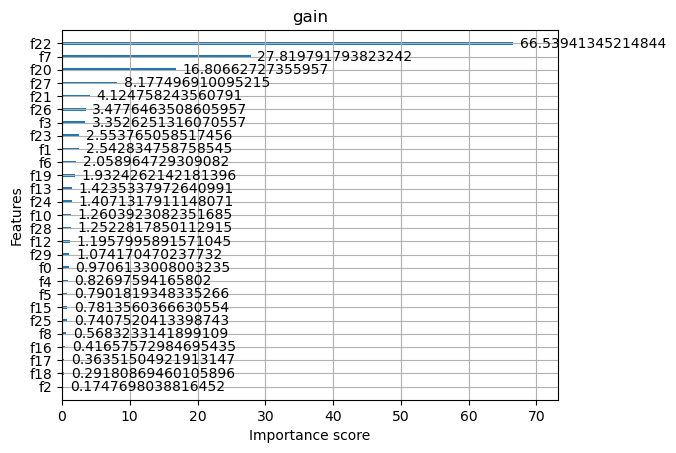

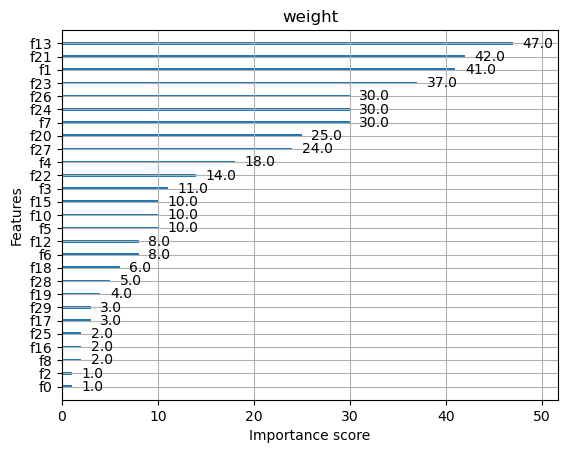

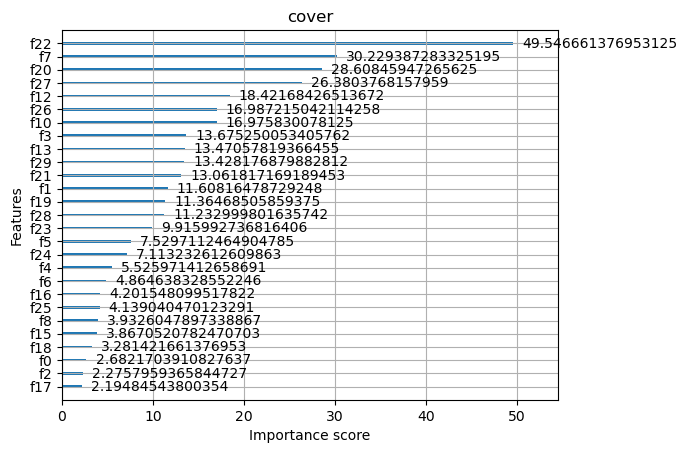

In [29]:
# 피쳐의 중요도 추출: 피쳐가 트리를 분기할때 손실함수를 얼마나 줄이는데 기여했는지를 측정

fig = plt.figure(figsize=(10,5))

# 분기시 얻은 평균 정보 이득, 모델 성능 향상 (기여도)
plot_importance(xgb_clf, importance_type='gain')  # 얘 많이 씀
plt.title('gain')
# 트리 분기에서 사용된 횟수 (빈도)
plot_importance(xgb_clf, importance_type='weight')
plt.title('weight')
# 분기시 처리한 데이터 샘플의 양(커버리지:데이터의 영향 범위)
plot_importance(xgb_clf, importance_type='cover')
plt.title('cover')

plt.show()


In [30]:
# XGBoost

In [31]:
# XGBoost에서 importance_type별 점수를 받아올수 있다. -> dict
# .get_booster() : 내부 트리구조와 매개변수 저장되잇음
# get_score() : 피처이름 - 점수 dict

print(xgb_clf.get_booster().get_score(importance_type='gain'))
print(xgb_clf.get_booster().get_score(importance_type='weight'))
print(xgb_clf.get_booster().get_score(importance_type='cover'))

{'f0': 0.9706133008003235, 'f1': 2.542834758758545, 'f2': 0.1747698038816452, 'f3': 3.3526251316070557, 'f4': 0.82697594165802, 'f5': 0.7901819348335266, 'f6': 2.058964729309082, 'f7': 27.819791793823242, 'f8': 0.5683233141899109, 'f10': 1.2603923082351685, 'f12': 1.1957995891571045, 'f13': 1.4235337972640991, 'f15': 0.7813560366630554, 'f16': 0.41657572984695435, 'f17': 0.36351504921913147, 'f18': 0.29180869460105896, 'f19': 1.9324262142181396, 'f20': 16.80662727355957, 'f21': 4.124758243560791, 'f22': 66.53941345214844, 'f23': 2.553765058517456, 'f24': 1.4071317911148071, 'f25': 0.7407520413398743, 'f26': 3.4776463508605957, 'f27': 8.177496910095215, 'f28': 1.2522817850112915, 'f29': 1.074170470237732}
{'f0': 1.0, 'f1': 41.0, 'f2': 1.0, 'f3': 11.0, 'f4': 18.0, 'f5': 10.0, 'f6': 8.0, 'f7': 30.0, 'f8': 2.0, 'f10': 10.0, 'f12': 8.0, 'f13': 47.0, 'f15': 10.0, 'f16': 2.0, 'f17': 3.0, 'f18': 6.0, 'f19': 4.0, 'f20': 25.0, 'f21': 42.0, 'f22': 14.0, 'f23': 37.0, 'f24': 30.0, 'f25': 2.0, 'f26'

In [32]:

# XGBoost 모델에서 중요도 가져오기 (dict)
importance_gain = xgb_clf.get_booster().get_score(importance_type='gain')
importance_weight = xgb_clf.get_booster().get_score(importance_type='weight')
importance_cover = xgb_clf.get_booster().get_score(importance_type='cover')

# 데이터 프레임으로 변환 : dict에서 keys, values 분리 : 둘다 컬럼으로 만든다
df_gain = pd.DataFrame({'Feature': list(importance_gain.keys()), 
                        'Importance': list(importance_gain.values())})
df_weight = pd.DataFrame({'Feature': list(importance_weight.keys()), 
                          'Importance': list(importance_weight.values())})
df_cover = pd.DataFrame({'Feature': list(importance_cover.keys()), 
                         'Importance': list(importance_cover.values())})

# 값으로 정렬 (중요도 순), 상위 10개 피처 선택 -> Series
top_gain = df_gain.sort_values(by='Importance', ascending=False).head(10)['Feature']
top_weight = df_weight.sort_values(by='Importance', ascending=False).head(10)['Feature']
top_cover = df_cover.sort_values(by='Importance', ascending=False).head(10)['Feature']

# 피처 이름 리스트 추출
features_gain = top_gain.tolist()
features_weight = top_weight.tolist()
features_cover = top_cover.tolist()

# 중복된 피처를 저장할 리스트
common_features = []

# 중복 피처 찾기
for feature in features_gain:  # Gain 기준으로 순회
    count = 1  # 중복된 횟수를 카운트
    if feature in features_weight:
        count += 1
    if feature in features_cover:
        count += 1
    if count >= 2:  # 2개 이상 중복되면 리스트에 추가
        common_features.append(feature)
        
print('중요도 2개 이상인 특성: ', common_features)

중요도 2개 이상인 특성:  ['f22', 'f7', 'f20', 'f27', 'f21', 'f26', 'f3', 'f23', 'f1']


In [33]:
print(df_gain.keys) # 0~29 인덱스 번호로 사용할수 있다. 
# 피처2개 삭제한 데이터를 넣어준 것이므로 답이나 삭제한 환자id 등은 제외된다. X와 매핑됨

<bound method NDFrame.keys of    Feature  Importance
0       f0    0.970613
1       f1    2.542835
2       f2    0.174770
3       f3    3.352625
4       f4    0.826976
5       f5    0.790182
6       f6    2.058965
7       f7   27.819792
8       f8    0.568323
9      f10    1.260392
10     f12    1.195800
11     f13    1.423534
12     f15    0.781356
13     f16    0.416576
14     f17    0.363515
15     f18    0.291809
16     f19    1.932426
17     f20   16.806627
18     f21    4.124758
19     f22   66.539413
20     f23    2.553765
21     f24    1.407132
22     f25    0.740752
23     f26    3.477646
24     f27    8.177497
25     f28    1.252282
26     f29    1.074170>


In [34]:
# 위 결과를 기준으로 원본에서 피처를 추출
select_features = [22, 7, 20, 27, 21, 26, 3, 23, 1] # 골라올 피처 인덱스

select_data = {idx: list(X[:, idx]) for idx in select_features}
# 인덱스 번호를 순회해서 원본에서 행전체, 컬럼(인덱스번호)를 가져와 dict로 저장. 키값= idx

In [35]:
print(select_data.keys()) # 키값이 들어갔는지 확인 (각 열의 값이 리스트로 들어가있다.)

print(select_data[22][0:5])  # 피처 9개 추출한 데이터
print(X[0:5,22])          # 원본array : 같은위치를 슬라이싱해서 원본데이터와 값이 같은지 확인
#

print(len(select_data[22]))  # 키 하나안에 들어있는 갯수확인
print(len(X[:,22]))  # 샘플수 확인

dict_keys([22, 7, 20, 27, 21, 26, 3, 23, 1])
[np.float64(184.6), np.float64(158.8), np.float64(152.5), np.float64(98.87), np.float64(152.2)]
[184.6  158.8  152.5   98.87 152.2 ]
569
569


In [36]:
X_train[:,0].shape

(455,)

In [37]:
select_df= pd.DataFrame(select_data)
select_df.head()  # 9피처만 고른 df

,22,7,20,27,21,26,3,23,1
0,184.60,0.14710,25.38,0.2654,17.33,0.7119,1001.0,2019.0,10.38
1,158.80,0.07017,24.99,0.1860,23.41,0.2416,1326.0,1956.0,17.77
2,152.50,0.12790,23.57,0.2430,25.53,0.4504,1203.0,1709.0,21.25
3,98.87,0.10520,14.91,0.2575,26.50,0.6869,386.1,567.7,20.38
4,152.20,0.10430,22.54,0.1625,16.67,0.4000,1297.0,1575.0,14.34


In [38]:
select_df.info() # 샘플수 동일

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   22      569 non-null    float64
 1   7       569 non-null    float64
 2   20      569 non-null    float64
 3   27      569 non-null    float64
 4   21      569 non-null    float64
 5   26      569 non-null    float64
 6   3       569 non-null    float64
 7   23      569 non-null    float64
 8   1       569 non-null    float64
dtypes: float64(9)
memory usage: 40.1 KB


In [39]:
X.shape, y.shape

# select_data = dict
# select_df= df
# 레이블: 인코딩 되있음

((569, 30), (569,))

In [40]:
# 전처리 함수 2 : 1. 원본 복사만 하도록 수정/ 2.답은 이미 분리되 있음 / 3. 새로운 df에만 쓸것이므로 함수명을 바꿔줬다. 
def get_preprocessed_new_df(df=None):
    df_copy = df.copy() # 복사본 만들기
    return df_copy

In [41]:
# 전처리 데이터 분리 함수 2 : 레이블 분리되있음, 레이블인코딩도 필요없음, 전처리만 하면됨 : (데이터프레임, 답)
def get_train_test_dataset_new(select_df=None, label= None):  
    X_features = select_df.copy() # 분리 필요없으므로 원본 복사해서 대입
    y_target = label    # 레이블
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    X_features = std.fit_transform(X_features)
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.2, random_state=1, stratify=y_target 
    )  # stratify=y_target: 답의 비율 맞춰서 나눔
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환 

In [42]:
# 데이터 분리 : 피처 고른 원본 = select_df
X_train, X_test, y_train, y_test = get_train_test_dataset_new(select_df, y) # 학습/테스트 분리
X_train.shape, X_test.shape     # 훈련 / 테스트 샘플수 확인 ((455, 9), (114, 9)) :피처는 9개로 줄어있다. 

((455, 9), (114, 9))

In [43]:
# 3 1 로지스틱 회귀  : 표준정규화적용 
lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear',  # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2',  # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

lr_result = get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test) 
# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.998)}

# {'오차행렬': [[71, 1], [1, 41]], '정확도': 0.9825, '정밀도': 0.9762, '재현율': 0.9762, 'F1': 0.9762, 'AUC': np.float64(0.9977)}

# 더 못맞춤..
# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.998)}

{'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.998)}


In [44]:
# 3 2 svc
svm_clf = SVC(
    kernel='linear',    # 결정경계 : 비선형
    gamma= 0.03,   # 얼마나 곡선을 줄것인지 (0.1정도도 오버피팅됨.. 1/특성이라고 해서 이렇게 해봄)
    C= 1.0,         # 패널티 = 규제 (오버피팅에 영향줌)
    probability=True,  # 예측 확률 반환 지정해줘야함
    random_state=1    # seed 
)

# svc  : 전처리 없음
svm_result = get_model_train_eval(svm_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9964)}

# {'오차행렬': [[70, 2], [2, 40]], '정확도': 0.9649, '정밀도': 0.9524, '재현율': 0.9524, 'F1': 0.9524, 'AUC': np.float64(0.997)}

# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9974)}

{'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9974)}


In [45]:
# 3 3 XGBoost 
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate = 0.1, 
    max_depth = 3, 
    eval_metric='logloss',
    random_state=1,
    n_jobs=-1
)

xgb_result = get_model_train_eval(xgb_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9854)}
# 여기서 중요도 추출한거라서 약간 좋아짐

{'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9854)}


In [46]:
# 3 4 랜덤포레스트
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth = 5,
    criterion='gini',
    random_state=1,
    n_jobs=-1
)

forest_result = get_model_train_eval(forest_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9934)}


{'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9934)}


In [47]:
X_test.shape

(114, 9)

# 3차 결과 저장 ...
add_result_dict(lr_metric, lr_result)
add_result_dict(svm_metric, svm_result)
add_result_dict(forest_metric, forest_result)
add_result_dict(xgb_metric, xgb_result)

In [48]:
### 4 PCA 차원축소 : 주성분의 개수: 30->15 / 2차:  pca=PCA(n_components=8)
n_components_=15


In [49]:
# 전처리 데이터 분리 함수: 3 PCA 적용
def get_train_test_dataset(df=None):  # df가 None이면 에러라서 if를 주면 좋다.  if not df: # df가 None 아니면 아래 코드 실행
    df_copy = get_preprocessed_df(df) # Time 피쳐 drop하는 함수. df 없으면 여기서 에러가 남
    X_features = df_copy.iloc[:,1:] # 데이터 분리
    y_target = df_copy.iloc[:,0]    # 레이블 분리
    from sklearn.preprocessing import StandardScaler # 정규화
    std = StandardScaler()
    X_features = std.fit_transform(X_features)
    from sklearn.decomposition import PCA #차원축소
    pca=PCA(n_components=n_components_)
    X_features_pca = pca.fit_transform(X_features) 
    # 레이블 인코딩  : 정규화 등은 이 위에서 실행
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()  
    y_target=le.fit_transform(y_target)  # -> ndarray
    # 학습/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features_pca, y_target, test_size=0.2, random_state=1, stratify=y_target 
    )  # stratify=y_target: 답의 비율 맞춰서 나눔
    return X_train, X_test, y_train, y_test # 학습/테스트 데이터 반환 

In [50]:
X_test.shape

(114, 9)

In [51]:
X_train, X_test, y_train, y_test = get_train_test_dataset(cancer_df) # 데이터 분리

In [52]:
# 4 1 로지스틱 회귀  : 표준정규화적용 
lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear',  # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2',  # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

lr_result = get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test) 
# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.998)}

# {'오차행렬': [[71, 1], [1, 41]], '정확도': 0.9825, '정밀도': 0.9762, '재현율': 0.9762, 'F1': 0.9762, 'AUC': np.float64(0.9977)}

# 더 못맞춤..
# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.998)}

# 환자 아닌 사람이 병원에와서 더 검사를 받았다.
# {'오차행렬': [[69, 3], [1, 41]], '정확도': 0.9649, '정밀도': 0.9318, '재현율': 0.9762, 'F1': 0.9535, 'AUC': np.float64(0.9964)}

{'오차행렬': [[69, 3], [1, 41]], '정확도': 0.9649, '정밀도': 0.9318, '재현율': 0.9762, 'F1': 0.9535, 'AUC': np.float64(0.9964)}


In [53]:
# 4 2 svc
svm_clf = SVC(
    kernel='linear',    # 결정경계 : 비선형
    gamma= 0.03,   # 얼마나 곡선을 줄것인지 (0.1정도도 오버피팅됨.. 1/특성이라고 해서 이렇게 해봄)
    C= 1.0,         # 패널티 = 규제 (오버피팅에 영향줌)
    probability=True,  # 예측 확률 반환 지정해줘야함
    random_state=1    # seed 
)

# svc  : 전처리 없음
svm_result = get_model_train_eval(svm_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9964)}

# {'오차행렬': [[70, 2], [2, 40]], '정확도': 0.9649, '정밀도': 0.9524, '재현율': 0.9524, 'F1': 0.9524, 'AUC': np.float64(0.997)}

# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9974)}

# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9974)}

{'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9974)}


In [54]:

# 4 3 XGBoost 
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate = 0.1, 
    max_depth = 3, 
    eval_metric='logloss',
    random_state=1,
    n_jobs=-1
)

xgb_result = get_model_train_eval(xgb_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# 여기서 중요도 추출한거라서 약간 좋아짐
# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9854)}

# 환자 아닌 사람이 병원에와서 더 검사를 받았다.
# {'오차행렬': [[69, 3], [2, 40]], '정확도': 0.9561, '정밀도': 0.9302, '재현율': 0.9524, 'F1': 0.9412, 'AUC': np.float64(0.9964)}

{'오차행렬': [[69, 3], [2, 40]], '정확도': 0.9561, '정밀도': 0.9302, '재현율': 0.9524, 'F1': 0.9412, 'AUC': np.float64(0.9964)}


In [ ]:

# 4 4 랜덤포레스트
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth = 5,
    criterion='gini',
    random_state=1,
    n_jobs=-1
)

forest_result = get_model_train_eval(forest_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9934)}

# 환자 아닌 사람이 병원에와서 더 검사를 받았다. 진단이 제대로 되서 몇명더 살렸다
# {'오차행렬': [[68, 4], [2, 40]], '정확도': 0.9474, '정밀도': 0.9091, '재현율': 0.9524, 'F1': 0.9302, 'AUC': np.float64(0.9838)}


{'오차행렬': [[68, 4], [2, 40]], '정확도': 0.9474, '정밀도': 0.9091, '재현율': 0.9524, 'F1': 0.9302, 'AUC': np.float64(0.9838)}


# 결과 저장 ...
add_result_dict(lr_metric, lr_result)
add_result_dict(svm_metric, svm_result)
add_result_dict(forest_metric, forest_result)
add_result_dict(xgb_metric, xgb_result)

In [ ]:
### 4 PCA 차원축소 : 주성분의 개수: 30->15 / 2차: 
n_components_= 4


In [57]:
X_train, X_test, y_train, y_test = get_train_test_dataset(cancer_df) # 데이터 분리

In [ ]:
# 4 1 로지스틱 회귀  : 표준정규화적용 
lr_clf = LogisticRegression(
    max_iter=100,
    solver='liblinear',  # 이진분류, l1,l2 사용, 작은 데이터셋
    penalty = 'l2',  # L2규제
    C=50, # 규제강도 1.0 은 강한규제
    n_jobs=-1 # CPU 코어
)

lr_result = get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test) 
# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.998)}

# {'오차행렬': [[71, 1], [1, 41]], '정확도': 0.9825, '정밀도': 0.9762, '재현율': 0.9762, 'F1': 0.9762, 'AUC': np.float64(0.9977)}

# 더 못맞춤.. 사망자가 늘었다. 
# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.998)}

# 환자 아닌 사람이 병원에와서 더 검사를 받았다. 사망자가 늘엇다.
# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9974)}

{'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9974)}


In [ ]:
# 4 2 svc
svm_clf = SVC(
    kernel='linear',    # 결정경계 : 비선형
    gamma= 0.03,   # 얼마나 곡선을 줄것인지 (0.1정도도 오버피팅됨.. 1/특성이라고 해서 이렇게 해봄)
    C= 1.0,         # 패널티 = 규제 (오버피팅에 영향줌)
    probability=True,  # 예측 확률 반환 지정해줘야함
    random_state=1    # seed 
)

# svc  : 전처리 없음
svm_result = get_model_train_eval(svm_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9964)}

# {'오차행렬': [[70, 2], [2, 40]], '정확도': 0.9649, '정밀도': 0.9524, '재현율': 0.9524, 'F1': 0.9524, 'AUC': np.float64(0.997)}

# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9974)}

# 15
# {'오차행렬': [[71, 1], [2, 40]], '정확도': 0.9737, '정밀도': 0.9756, '재현율': 0.9524, 'F1': 0.9639, 'AUC': np.float64(0.9974)}
# 4   : 사망자가 늘었다.
# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.997)}

{'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.997)}


In [ ]:

# 4 3 XGBoost 
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate = 0.1, 
    max_depth = 3, 
    eval_metric='logloss',
    random_state=1,
    n_jobs=-1
)

xgb_result = get_model_train_eval(xgb_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# {'오차행렬': [[71, 1], [4, 38]], '정확도': 0.9561, '정밀도': 0.9744, '재현율': 0.9048, 'F1': 0.9383, 'AUC': np.float64(0.9937)}

# 여기서 중요도 추출한거라서 약간 좋아짐
# {'오차행렬': [[71, 1], [3, 39]], '정확도': 0.9649, '정밀도': 0.975, '재현율': 0.9286, 'F1': 0.9512, 'AUC': np.float64(0.9854)}

# 환자 아닌 사람이 병원에와서 더 검사를 받았다. 
# {'오차행렬': [[70, 2], [3, 39]], '정확도': 0.9561, '정밀도': 0.9512, '재현율': 0.9286, 'F1': 0.9398, 'AUC': np.float64(0.996)}

{'오차행렬': [[70, 2], [3, 39]], '정확도': 0.9561, '정밀도': 0.9512, '재현율': 0.9286, 'F1': 0.9398, 'AUC': np.float64(0.996)}


In [ ]:

# 4 4 랜덤포레스트
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth = 5,
    criterion='gini',
    random_state=1,
    n_jobs=-1
)

forest_result = get_model_train_eval(forest_clf, X_train, X_test, y_train, y_test)

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9917)}

# {'오차행렬': [[71, 1], [5, 37]], '정확도': 0.9474, '정밀도': 0.9737, '재현율': 0.881, 'F1': 0.925, 'AUC': np.float64(0.9934)}

# 환자 아닌 사람이 병원에와서 더 검사를 받았다. 사망자는 줄어든다 
# {'오차행렬': [[70, 2], [3, 39]], '정확도': 0.9561, '정밀도': 0.9512, '재현율': 0.9286, 'F1': 0.9398, 'AUC': np.float64(0.9927)}


{'오차행렬': [[70, 2], [3, 39]], '정확도': 0.9561, '정밀도': 0.9512, '재현율': 0.9286, 'F1': 0.9398, 'AUC': np.float64(0.9927)}


# 결과 저장 ...
add_result_dict(lr_metric, lr_result)
add_result_dict(svm_metric, svm_result)
add_result_dict(forest_metric, forest_result)
add_result_dict(xgb_metric, xgb_result)

In [ ]:
# 파이프라인 구성
pipe_lr= make_pipeline(
    pca(n_components=4)
)


In [ ]:
# 하이퍼옵트 공간 구성

In [ ]:
# 이상치 iqr 제거해서 pca 실행해서. 전처리후 하이퍼옵트

In [ ]:
# PCA 사용법

# sklearn PCA : 라이브러리 사용 : decomposition  분해

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# n_components=2차원으로 차원축소 = 주성분개수 
# # 얘도 하이퍼파라미터 = feature important(특성선택하고 비슷) = 무조건 많이 넣는다고 좋은거 아님 체크해봐야함
pca=PCA(n_components=7)
# 학습 모델 선언 
lr=LogisticRegression(
    multi_class='ovr'
    , random_state=1
    , solver='lbfgs'   
)
# 차원축소
X_train_pca=pca.fit_transform(X_train_std)
X_test_pca=pca.transform(X_test_std)

# 모델 훈련: 학습하기
lr.fit(X_train_pca, y_train)

from sklearn.metrics import accuracy_score   # 정확도 체크

y_pred=lr.predict(X_test_pca)

print(f'정확도: {accuracy_score(y_pred, y_test):.3f}')



정확도: 1.000


c:\ProgramData\anaconda3\envs\pyml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# eval_metric='logloss'  # 평가 지표, logloss 2진분류...


from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(
    n_estimators=1000  # 약한학습기
    , early_stopping_rounds=100  # 조기 종료 (검증 데이터의 logloss가 100회 오차가 개선되지 않는다면 종료)
    , eval_metric='logloss'  # 평가 지표, logloss 2진분류
    , learning_rate=0.1  # 학습률
    , max_depth=3
)

# 조기종료가 항상 좋을까? = 얘도 하이퍼 파라미터임.. 항상 맞는 답이 아니다.
# 테스트 데이터 설정
evals=[(X_test,y_test)]  # 검증 데이터 (X_test, y_test)
xgb_wrapper.fit(X_train, y_train, eval_set=evals, verbose=True)  # verbose=False : 학습과정 출력 안함

In [ ]:
# 하이퍼 옵트
# serch space 공간 설정 : 사실은 이값은 전혀 모름.. 내가 알아서 찾아야됨

# 하이퍼 파라미터 설정 
# dapth(정수) 5~20까지 1 간격
# min_child_weight(정수) 1,2  :트리에서 추가적으로 가지를 나눌지. 클수록 노드 분할이 덜됨
# calsample_bytree 0.5~1 사이 값 :트리 생성에 필요한 피처(칼럼)를 임의로 샘플링
# learning_rate 0.01~0.2

xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 20, 1),  # 5~20까지 1 간격, 정수
    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),  
    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),  
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1) 
}

In [ ]:
# 베스트 하이퍼 파라미터 찾기
trial_val=Trials()  # 상태 정보를 저장: 하이퍼 파라미터를 저장할 객체 생성

best= fmin(
    fn=objective_func,  # 최적화할 함수
    space=xgb_search_space ,  # 검색 공간
    algo=tpe.suggest,  # 알고리즘: 
    max_evals=50,  # 최대 평가 횟수
    trials=trial_val,  # 상태 정보 저장 객체
    rstate=np.random.default_rng(seed=9) # 랜덤 시드 고정
)

print(f'BEST: {best}')  # 최적의 하이퍼 파라미터

100%|██████████| 50/50 [00:11<00:00,  4.37trial/s, best loss: -0.967047170907401] 
BEST: {'colsample_bytree': np.float64(0.7923560109541058), 'learning_rate': np.float64(0.1938940946651398), 'max_depth': np.float64(16.0), 'min_child_weight': np.float64(2.0)}


In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=1000,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                            , early_stopping_rounds=50
                            , eval_metric='logloss'
                           )

In [ ]:
set_config(display='diagram')
pipe_lr

# 중요. 파이프라인 작용순서 확인하기 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [ ]:

# n_splits=10 모델이 10개 10번 학습: 성능평가 -> 정확도 10개  
kfold=StratifiedKFold(n_splits=10).split(X_train, y_train)  
scores=[]

print(X_train.shape)   #(455, 30)
# : test 데이터는 여기 안넣음 : 성능평가에만 사용하는거 주의
# 훈련데이터
# train = 인덱스값 이라는 거 주의
for k,(train, test) in enumerate(kfold):
    # print(k, train.shape, validation.shape)
    pipe_lr.fit(X_train[train], y_train[train])
    score=pipe_lr.score(X_train[test], y_train[test]) # 정확도
    scores.append(score)
    print(f'{score:.3f}')


In [ ]:
# 평균정확도 : 여기까지 오늘 코드 중요 : 평균정확도: 0.950
print(f'평균정확도: {np.mean(scores):.3f}')

평균정확도: 0.950


In [ ]:

scores=cross_val_score(
    estimator=pipe_lr
    , X=X_train
    , y=y_train
    , cv=10  # 10개 k-fold로 나눔 
    , n_jobs=1
)
scores  # 10개 fold의 정확도 
# array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
    #    0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])
print(f'cv 정확도 점수: {np.mean(scores):.3f}')

In [15]:
scores 

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

In [ ]:
# cross_validate() scoring 평가지표를 설정할 수 있다 : 시간 체크할때 필요
scores=cross_validate(
    estimator=pipe_lr
    , X=X_train
    , y=y_train
    , scoring=['accuracy']
    , cv=10
    , n_jobs=-1  # 전체 다 쓴다는 의미
)
scores  # -> dict 
# 'fit_time' : 학습시간 [각 모델 걸린 시간]
# 'score_time': 검증 시간
# 'test_accuracy': 테스트데이터(validation 부분의 정확도)  : 데이터 만개정도는 해야. 지금 너무 적다. 
#  'test_accuracy' 얘만 갖다 평균내보기로


In [17]:
scores['test_accuracy'] 
# dict이므로 키값으로 꺼내볼수 있음

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

In [18]:
print('CV 평균적인 정확도: ', np.mean(scores['test_accuracy']))
print('표준편차: ', np.std(scores['test_accuracy']))

CV 평균적인 정확도:  0.9495169082125603
표준편차:  0.013854294239660376


In [ ]:
# cross_val_predict : method= 'predic_proba'( 예측확률 쓰려고 쓰는거임)
# from sklearn.model_selection import cross_val_predict

preds=cross_val_predict(
    estimator=pipe_lr
    , X=X_train
    , y=y_train
    , cv=10
    , method='predict_proba'
    , n_jobs=-1
)
preds.shape   # (455,2) 455샘플 - 2개 답
preds


array([[9.94012059e-01, 5.98794102e-03],
       [7.64607902e-01, 2.35392098e-01],
       [9.72784305e-01, 2.72156951e-02],
       [8.41865784e-01, 1.58134216e-01],
       [9.97161118e-01, 2.83888175e-03],
       [9.99805436e-01, 1.94563743e-04],
       [9.99329649e-01, 6.70351232e-04],
       [2.09400816e-06, 9.99997906e-01],
       [1.28535609e-01, 8.71464391e-01],
       [7.71820369e-04, 9.99228180e-01],
       [9.99578386e-01, 4.21613740e-04],
       [4.33816483e-02, 9.56618352e-01],
       [9.90371107e-01, 9.62889266e-03],
       [2.15163023e-01, 7.84836977e-01],
       [9.97801270e-01, 2.19873031e-03],
       [9.99330305e-01, 6.69694627e-04],
       [6.67775699e-05, 9.99933222e-01],
       [1.90352496e-04, 9.99809648e-01],
       [3.13147080e-01, 6.86852920e-01],
       [9.11521044e-03, 9.90884790e-01],
       [1.83979175e-02, 9.81602083e-01],
       [9.99830512e-01, 1.69488236e-04],
       [8.71960093e-01, 1.28039907e-01],
       [9.99945310e-01, 5.46895621e-05],
       [4.742090

In [21]:
# 파이프라인 설정
pipe_lr=make_pipeline(
    StandardScaler()  # 정규화만함 / 피처 셀렉션 안했음
    , LogisticRegression(
        penalty='l2'
        , max_iter=10000 # 반복 디폴트는 1000
    )
)

train_sizes, train_scores, test_scores = learning_curve(   #-> 튜플 3개 반환 (test는 검즘데이터임)
    estimator=pipe_lr  
    , X=X_train
    , y=y_train
    , train_sizes=np.linspace(0.1,1.0,10)  # 0.1,1.0까지 10개 구간으로 나눔 : 검증데이터와 휸련데이터를 나눌 비율
    , cv=10  
    , n_jobs=1
)

print(train_sizes.shape, train_scores.shape)

# 이부분 다시 확인할것

(10,) (10, 10)


In [22]:
np.linspace(0.1,1.0,10)    
# 전체데이터에서 0.1씩 가져다 학습시키고 마지막에는 1.0(전체)갖다가 학습시키라는 의미  10개 구간으로 나눔 
# 처음에는 검증데이터로 남겨두는 양이 0.9 훨컸다가 점점 줄어든다. 
# 그래프 가로축: 학습한 샘플의 갯수


# train_scores = 2차원 axis가 있음. 
# 0.1일때(row 40개일때) cross validation 10번반복(컬럼= 정확도)  ==> mean 하면 정확도의 평균이 나오겠지..
# 0.2일때(row 81개일때) cross validation 10번반복(컬럼= 정확도) ..  요런식의 2차원임

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

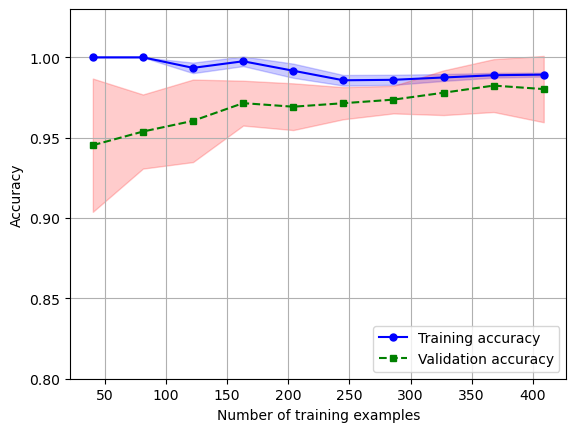

In [23]:
# 시계열 데이터에 많이쓴다. 
# 
# 분산이 크다 == 오차가 심해 정확도가 떨어진다.  

# print(train_sizes)  # 훈련 샘플 갯수-> [ 40  81 122 163 204 245 286 327 368 409]
# print(train_scores[0])   # [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 40개 데이터로 학습한 결과의 정확도: 다 맞았다는 의미임
# 예상: 데이터가 많아지면 외우는게 줄어들거같다~
train_mean=np.mean(train_scores, axis=1)   # 각 정확도의 평균과 분산을 구해둔다. 여기까지는 구해둬야함
train_std=np.std(train_scores, axis=1) 
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores, axis=1) 

# 학습데이터 결과에 대한 선 그래프
plt.plot(
    train_sizes  # X= 훈련데이터의 개수
    , train_mean # y= 훈련 데이터, 예측값의 정확도
    , color='blue'
    , marker='o'
    , markersize=5
    , label='Training accuracy'
)

# 각각의 정확도에 대한 분산정도를 엔벨로프처럼 그리려고함 (y축으로) x는 샘플수
# 학습데이터 정확도에 대한 분산 
# plt.fill_between(x축, y1값, y2값)
plt.fill_between(
    train_sizes
    , train_mean+train_std   #  y1값,
    , train_mean-train_std   #  y2값,
    , alpha=0.2
    ,color='blue'
)


# 테스트 데이터의 정확도에 대한 선 그래프
plt.plot(
    train_sizes  # X= 훈련데이터의 개수
    , test_mean
    , color='green'
    , linestyle='--'
    , marker='s'
    , markersize=5
    , label='Validation accuracy'
)

# 각각의 정확도에 대한 분산정도를 엔벨로프처럼 그리려고함 y축으로 x는 샘플수
# 
plt.fill_between(
    train_sizes
    , test_mean+test_std   #  y1값,
    , test_mean-test_std   #  y2값,
    , alpha=0.2
    , color='red'
)


plt.grid()

plt.ylim([0.8, 1.03])  # 축을 좀더 알아보기 쉽게 그냥두면 그래프 면적만큼만 나온다.

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

plt.show()

# 예측값이 1이면 다 맞춤

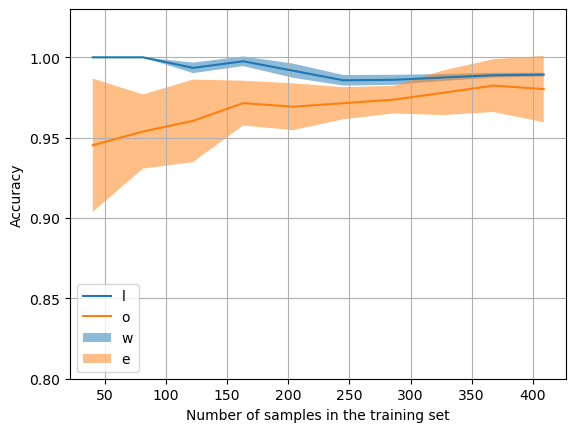

In [ ]:
# 위 샐 내용을 실행해주는 클래스

# from sklearn.model_selection import LearningCurveDisplay

disp=LearningCurveDisplay(
    train_sizes=train_sizes   #  요 값들은 만들어둬야한다. learning_curve()메소드로 만들어둬야됨
    , train_scores=train_scores
    , test_scores=test_scores
    , score_name='Accuracy'
)

disp.plot(score_type='both')
plt.legend('lower right')

plt.grid()
plt.ylim([0.8, 1.03]) 


plt.show()




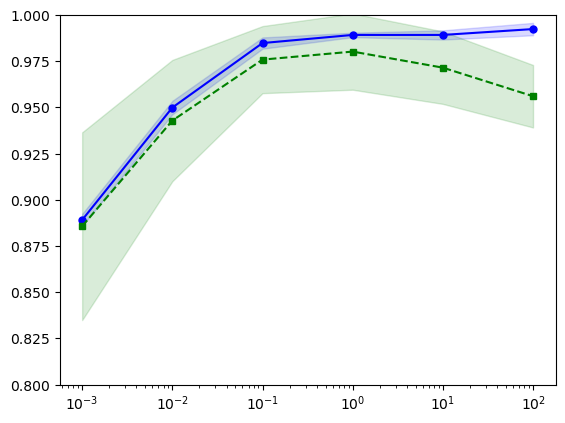

In [ ]:
# 6.3.2 검증곡선
# from sklearn.model_selection import validation_curve

# 규제에 적용할 값을 리스트로 생성, 이 값은 좋은것인지 모른다? (해봐야 아는거고 좀더 정밀하게 접근해야된다.)
# 첫번째 최적 값은 모른다 => 그리드 서치 사용해야 된다. 
# 정밀하게 처리위해서 다른 패키지도 사용해야됨 : hyperOpt
param_range=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # 더 작거나 , 훨씬 클수있다.

# 검증곡선 생성: 베스트 C값을 찾는게 목적임
train_scores, test_scores= validation_curve(
    estimator=pipe_lr  # 여기 학습도 들어가있음. 베스트 모델을 생성하지는 않는다.
    , X=X_train
    , y= y_train
    , param_name='logisticregression__C'   # 그리드 서치와도 연결. 규제 이름써줌 
    , param_range=param_range
    , cv=10
)

# 계산
train_mean= np.mean(train_scores, axis=1)
train_std= np.std(train_scores, axis=1)   # mean으로 오타 냇었음
test_mean= np.mean(test_scores, axis=1)
test_std= np.std(test_scores, axis=1)   # mean으로 오타 냇었음


plt.plot(
    param_range
    , train_mean
    , color='blue'
    , marker='o'
    , markersize=5
    , label='Training Accuracy'
)

plt.fill_between(
    param_range
    , train_mean+train_std
    , train_mean-train_std
    , alpha=0.15
    , color='blue'
)


plt.plot(
    param_range
    , test_mean
    , color='green'
    , marker='s'
    , linestyle='--'
    , markersize=5
    , label='Training Accuracy'
)

plt.fill_between(
    param_range
    , test_mean+test_std
    , test_mean-test_std
    , alpha=0.15
    , color='green'
)


# # 차트 
# plt.plot(param_range, train_mean, color='blue',marker='o'
#         , markersize=5, label='Training Accuracy'
# )
# plt.fill_between(param_range, train_mean+train_std
#             , train_mean-train_std, alpha=0.15, color='blue'
# )

# plt.plot(param_range, test_mean, color='green',marker='s', linestyle='--'
#         , markersize=5, label='Training Accuracy'
# )
# plt.fill_between(param_range, test_mean+test_std
#             , test_mean-test_std, alpha=0.15, color='green'
# )



plt.ylim([0.8, 1.0])
plt.xscale('log')
plt.show()



In [ ]:
# 6.4 그리드서치 :
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

pipe_svc= make_pipeline(
    StandardScaler()
    , SVC(random_state=1) # 기본모델 생성
)

param_range=[0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid=[
    {
        'svc__C' : param_range   # 이 값을 넣었을때 각각의 조합의 정확도를 체크할수있다. 8개
        , 'svc__kernel' : ['linear']   # 여러개 넣수 있어서 리스트 써줌 
    }
    ,{
        'svc__C' : param_range   # 8
        , 'svc__gamma' : param_range    # 8  
        , 'svc__kernel': ['rbf']
    }
]
# (8개 + 8*8 = 72개 )*10 = 720개 모델 나옴

gridsearch = GridSearchCV(   # 베스트 모델찾기: best param ==> 성능평가 scoring=
    estimator=pipe_svc  # 파이프라인 넣고
    , param_grid=param_grid  # 내가써준 하이퍼 파라미터 넣어줌
    , scoring='accuracy' # 평가방법 : 지금은 정확도로 찾아볼 생각임
    , cv=10     # 모델 10개
    , refit=True  # 모델도 만들꺼임: false = 모델 학습은 안한다. (주의) True가 디폴트, 대신 시간쪼금더 걸림
    , n_jobs=-1 # cpu 다 쓰겠음
)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                     1000.0],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                     1000.0],
                          'svc__gamma': [0.001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0, 1000.0],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy')

In [27]:
# best 정확도, 파라미터 찾아줌 : RL 아까선형 썼던거보다 정확도가 쪼금더 나온듯하다~

print(f'최적의 정확도: {gridsearch.best_score_:.3f}')
print(f'최적의 파라미터: {gridsearch.best_params_}')    

최적의 정확도: 0.985
최적의 파라미터: {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [28]:
y_preds=gridsearch.best_estimator_.predict(X_test)   
# best 모델 : 테스트 데이터 돌려봄 = 일반화 성능

print(f'일반화성능(테스트데이터 정확도): {accuracy_score(y_pred, y_test):.3f}')

일반화성능(테스트데이터 정확도): 0.956


In [29]:
# return_train_score 

In [ ]:
# 0401  6.5 혼동 행렬: 분류모델 성능평가지표
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.svm import SVC

# from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix

df = pd.read_csv(
    './wdbc.data'
    ,header=None
)
X=df.iloc[:,2:].values
y=df.iloc[:,1].values

le=LabelEncoder()
y=le.fit_transform(y)

X_train, X_test, y_train,y_test=train_test_split(
    X
    ,y
    ,test_size=0.2
    ,stratify=y
    ,random_state=1
)

pipe_svc=make_pipeline(
    StandardScaler()
    ,SVC(random_state=1) # 기본 모델 생성
)


In [31]:
pipe_svc.fit(X_train, y_train)  # 학습
y_pred=pipe_svc.predict(X_test) # 테스트 테이터로 예측
confmat= confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)
print('테스트답: ', y_test)
print('예측답  : ', y_pred)

# 현재는 이슈가 되는 부분: 
# 양성0으로 예측했는데 실제로 악성1 인경우 홍동행렬에서 2가 나온부분, 
# 이부분 오차를 줄이는게 중요  



[[71  1]
 [ 2 40]]
테스트답:  [1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1
 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 1]
예측답  :  [1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1
 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 1]


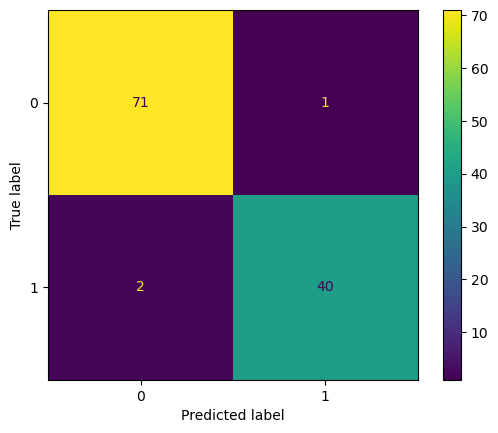

In [ ]:
# ConfusionMatrixDisplay  클래스.. 시각화 좀 쉽대네 - pipe, 테스트데이터, 테스트답 필요
# from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)

plt.show()

#  양성: Benigm 0, 악성: Malignant 1 (=> sort로 알파벳 순이 되므로 요렇게정리된다)

# 오차는 줄지 않음. 대각선의 서로다른 오차 부분은 서로 상충됨 한쪽이 늘면 한쪽은 줄어든다. 
# => 내가 필요한쪽의 오차는 일단 줄여야된다. 


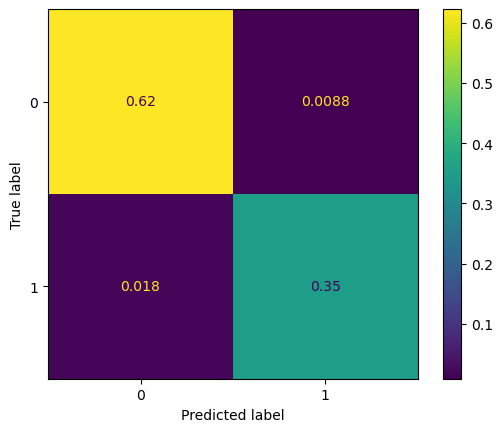

In [33]:
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, normalize='all')
# 정규화 normalize='all'  일반화성능은 0.97

In [35]:
# 같은 함수명 있으므로 주의
precision_score_= precision_score(y_true=y_test, y_pred=y_pred)
print(f'정밀도(예측): {precision_score_:.3f}')
recall_score_=recall_score(y_true=y_test, y_pred=y_pred)
print(f'재현율: {recall_score_:.3f}')
f1_score_=f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_score_:.3f}')

정밀도(예측): 0.976
재현율: 0.952
F1: 0.964


#### 재현율 (낮아야 됨)
- 암진단, 금융사기 
- 놓쳤을때 위험한 경우
    - 암이었는데 아니라고 예측 (이부분 비율 낮춰야함)

#### 정밀도 (낮아야 됨)
- 스팸메일, 추천시스템, 불만고객
- 잘못 긍정(positive)예측시에 비용이 큰 경우
    - 스팸아닌데 스팸으로 예측(스팸=positive)
    - 우수 고객인데 아니라고 예측 (우수고객=positive)


- 플젝 목적에 맞게 조절해야 됨
- 둘은 트레이드 오프 관계
- 조화롭게 조절하고싶으면 f1- score 봐야됨

In [37]:
# imbalanced-learn : 불균형 데이터를 다루는 패키지
# 불균형 데이터 아니지만 기냥 써보기로함
X.shape, y.shape, np.bincount(y)   #((569, 30), (569,), 답이 각각 몇개? array([357, 212]))

import imblearn



In [38]:
from imblearn.over_sampling import SMOTE